## 다른 Calibration Tech 이용


- Bottom Image 사용 X 그냥 밝기/대조/채도 조정

In [10]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [11]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]

In [12]:
from PIL import ImageEnhance

def enhance_image(image_path, brightness_factor, contrast_factor, saturation_factor, name):
    # 이미지 열기
    image = Image.open(image_path)
    
    # 이미지 보정을 위한 Enhancer 생성
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(brightness_factor)  # 밝기 조정
    
    enhancer = ImageEnhance.Contrast(enhanced_image)
    enhanced_image = enhancer.enhance(contrast_factor)  # 콘트라스트 조정
    
    enhancer = ImageEnhance.Color(enhanced_image)
    enhanced_image = enhancer.enhance(saturation_factor)  # 채도 조정
    
    # 보정된 이미지 저장
    enhanced_image.save(f'./data/box_img/enhanced/Top_{name}.jpg')

for i in range(len(top_path_list)):
    enhance_image(top_path_list[i], 1.5, 1.2, 1.0, i)
    
enhanced_top_path_list = [f'./data/box_img/enhanced/Top_{i}.jpg' for i in range(0, 127)]

- Reference 보정을 위해 기본값을 정하고 Weight를 줘서 보정을 해주면 되지 않을까?

### AutoML 먼저 시도

In [13]:
enhanced_top_avg_rgb = []
for i in range(len(enhanced_top_path_list)):
    top = Image.open(enhanced_top_path_list[i])
    top = np.array(top)
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    enhanced_top_avg_rgb.append([Top_R, Top_G, Top_B])

In [14]:
enhanced_top_avg_rgb = np.array(enhanced_top_avg_rgb)

In [15]:
#top avg rgb + thickness
Table_dataset = pd.DataFrame(np.concatenate([enhanced_top_avg_rgb, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset

,R,G,B,Thickness
0,17.2720,15.8976,10.6616,48.266667
1,17.9832,18.6944,15.5040,47.966667
2,18.4968,18.8264,13.0408,48.166667
3,15.9640,17.0520,11.6100,48.600000
4,8.3764,4.0788,1.8556,59.533333
...,...,...,...,...
122,0.7640,6.6616,37.4812,84.633333
123,0.7400,23.3572,56.2044,98.366667
124,1.0876,19.7220,65.4924,97.033333
125,1.0832,20.2668,59.5004,96.266667


In [16]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:,:-1], Table_dataset.iloc[:,-1], test_size=0.3, random_state=42)

In [17]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_corrected.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -49.02473024538901

Generation 2 - Current best internal CV score: -49.02473024538901

Generation 3 - Current best internal CV score: -48.66147220079428

Generation 4 - Current best internal CV score: -46.726340149542686

Generation 5 - Current best internal CV score: -46.726340149542686

Best pipeline: AdaBoostRegressor(StandardScaler(ZeroCount(input_matrix)), learning_rate=1.0, loss=exponential, n_estimators=100)


In [18]:
y_pred = tpot.predict(X_test)
y_pred

array([ 72.16666667,  62.45      ,  72.57301587,  98.58421053,
        92.65111112,  63.16666667,  72.57301587,  92.65111112,
        65.03888889, 109.50833333,  97.56190476,  62.07222222,
        82.94117647,  62.07222222,  83.11367521, 101.74444446,
        89.03049646,  82.62291667,  68.22222222,  82.65625   ,
        68.95238095,  62.97666667,  85.13836478, 153.3       ,
        48.6       , 124.4333333 , 100.92619047, 100.40416668,
        72.28333333,  85.13836478,  62.55833333,  72.16666667,
        71.83      , 105.88571427,  91.10384616, 101.47962962,
        71.23333333, 153.3       ,  75.55714286])

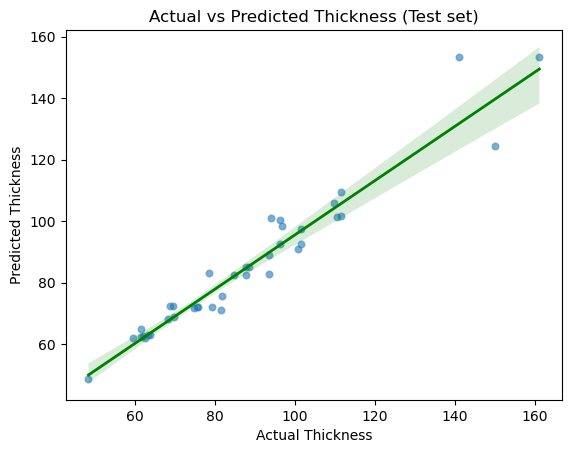

In [22]:
import statsmodels.api as sm
import seaborn as sns

# 그래프 그리기
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [20]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,72.166667
1,61.300000,62.450000
2,68.700000,72.573016
3,96.633333,98.584211
4,101.466667,92.651111
5,63.166667,63.166667
6,69.433333,72.573016
7,96.266667,92.651111
8,61.466667,65.038889
9,111.533333,109.508333


In [25]:
from sklearn.metrics import mean_squared_error
# 테스트 세트에서의 RMSE 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))

MSE: 46.083, RMSE: 6.788
